In [12]:
from setup import *
from utils import *

In [13]:
config = {
    # Rendering settings
    'spp': 16, # samples per pixel for rendering
    'threshold': 0.99,
    'bubble_scale': 0.75,
    'use_distorted_jar': True,
    
    # Grid Settings
    'cuboid_grid': {
        'xlength': 10.0, # length in cm along between end point bubbles along x-axis
        'ylength': 10.0,
        'zlength': 0.0,
        'xcount': 11, # number of bubbles in the grid along the x-axis
        'ycount': 11,
        'zcount': 1,
        'origin': [0.0, 0.0, -10.0], # origin of bubble grid
    },
    'cylindrical_grid': {
        'radius': 8.0,
        'height': 0.0,
        'rcount': 8,
        'mtcount': 36,
        'hcount':  1,
        'origin': [0.0, 0.0, -10.0],
    },

    # Circle detection settings
    'hough_params': {
        'method': cv2.HOUGH_GRADIENT_ALT,
        'dp': 1.5,
        'minDist': 10,
        'param1': 150,
        'param2': 0.9,
        'minRadius': 2,
        'maxRadius': 20
    }
}

160


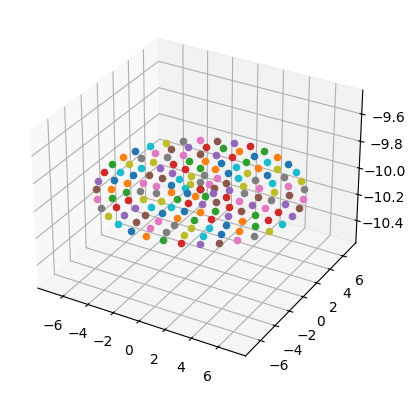

In [14]:
# grid = generate_cuboid_grid(**config['cuboid_grid'])
grid = generate_cylindrical_grid(**config['cylindrical_grid'])
print(len(grid))

# Visualize the grid...
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for point in grid:
    ax.scatter(point[0], point[1], point[2])

In [15]:
# Load in scene components
materials = create_materials(with_fluids=True)
components0 = load_components(materials)
if config['use_distorted_jar']:
    components0.pop('outer_jar_outer_surface')
    components0.update({
        'outer_jar_outer_surface_top': mi.load_dict({
            'type': 'ply',
            # Note: scene_dir and object_format are defined in setup.py
            'filename': scene_dir+'outer_jar_outer_surface_top_distorted'+object_format,
            'face_normals': False,
            'bsdf': materials['outer_jar_outer_surface_mat'],
        }),
        'outer_jar_outer_surface_bottom': mi.load_dict({
            'type': 'ply',
            'filename': scene_dir+'outer_jar_outer_surface_bottom'+object_format,
            'face_normals': False,
            'bsdf': materials['outer_jar_outer_surface_mat'],
        }),
    })
components1 = components0.copy()

# Remove all refractive surfaces from components0
components0.pop('viewports_outer', None)
components0.pop('viewports_inner', None)
components0.pop('outer_jar_outer_surface', None)
components0.pop('outer_jar_outer_surface_top', None)
components0.pop('outer_jar_outer_surface_bottom', None)
components0.pop('outer_jar_inner_surface', None)
components0.pop('inner_jar_outer_surface', None)
components0.pop('inner_jar_inner_surface', None)

sensor = create_sensor(sensor_number=2, sample_count=config['spp'])

2024-07-02 14:26:47 WARN main [PLYMesh] "outer_jar_outer_surface_top_distorted.ply": skipping unknown element "edge"

In [16]:
locations0 = [] # bubble image pixel locations without refractive surfaces
locations1 = [] # bubble image pixel locations *with* refractive surfaces

for point in grid:
    
    # Add the bubble to the scene
    components0.update({
        'bubble': mi.load_dict({
            'type': 'sphere',
            'focused-emitter': materials['emitter'],
            'to_world': mi.ScalarTransform4f.translate(point).scale(config['bubble_scale']),
        })
    })
    components1.update({
        'bubble': mi.load_dict({
            'type': 'sphere',
            'focused-emitter': materials['emitter'],
            'to_world': mi.ScalarTransform4f.translate(point).scale(config['bubble_scale']),
        })
    })

    scene0 = load_scene(components=components0, sensor=sensor)
    render0 = render(scene0, denoise=False)[:,:,0]
    trender0 = np.where(render0>config['threshold'], render0, 0).astype(np.uint8)
    circles0 = cv2.HoughCircles(trender0, **config['hough_params'])
    if circles0 is not None:
        locations0.append(circles0.reshape(-1, 3)[0])
    else:
        locations0.append(None)

    scene1 = load_scene(components=components1, sensor=sensor)
    render1 = render(scene1, denoise=False)[:,:,0]
    trender1 = np.where(render1>config['threshold'], render1, 0).astype(np.uint8)
    circles1 = cv2.HoughCircles(trender1, **config['hough_params'])
    if circles1 is not None:
        locations1.append(circles1.reshape(-1, 3)[0])
    else:
        locations1.append(None)


In [17]:
# If the location is None in either list of locations, remove the corresponding element in the other list as well
Nones0 = [i for i in range(len(locations0)) if locations0[i] is None]
for j in range(len(Nones0)):
    del locations0[Nones0[j]]
    del locations1[Nones0[j]]
    Nones0 = [i-1 for i in Nones0]

Nones1 = [i for i in range(len(locations1)) if locations1[i] is None]
for j in range(len(Nones1)):
    del locations0[Nones1[j]]
    del locations1[Nones1[j]]
    Nones1 = [i-1 for i in Nones1]

print(len(locations0))
print(locations0)
print("This should be empty: ", [i for i in range(len(locations0)) if locations0[i] is None])
print()
print(len(locations1))
print(locations1)
print("This should be empty: ", [i for i in range(len(locations1)) if locations1[i] is None])

158
[array([646.5     , 399.      ,  13.385484], dtype=float32), array([646.5     , 399.      ,  13.385484], dtype=float32), array([646.5     , 399.      ,  13.385484], dtype=float32), array([646.5     , 399.      ,  13.385484], dtype=float32), array([630.      , 399.      ,  13.575423], dtype=float32), array([633.      , 411.      ,  13.479059], dtype=float32), array([643.5      , 417.       ,  13.3274355], dtype=float32), array([654.      , 415.5     ,  13.285208], dtype=float32), array([661.5     , 405.      ,  13.211408], dtype=float32), array([661.5     , 393.      ,  13.198343], dtype=float32), array([654.      , 384.      ,  13.260918], dtype=float32), array([643.5      , 382.5      ,  13.3296585], dtype=float32), array([633.       , 388.5      ,  13.4578085], dtype=float32), array([612.      , 399.      ,  13.756398], dtype=float32), array([616.5     , 417.      ,  13.684554], dtype=float32), array([627.      , 429.      ,  13.516779], dtype=float32), array([642.      , 435.   

[639 400 396]


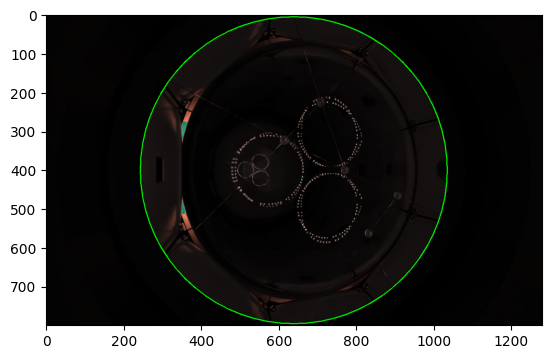

In [18]:
# Determine the portion of the renders that bounds the viewport (and potentially the jars)
components1.pop('bubble', None) # remove the bubble
sensor1 = create_sensor(sensor_number=2, sample_count=528)
scene = load_scene(components1, sensor1)
rend = np.array(256*render(scene, denoise=True), dtype=np.uint8)
rendr = rend[:,:,0]
hough_params_2 = {
    'method': cv2.HOUGH_GRADIENT_ALT,
    'dp': 1,
    'minDist': 5,
    'param1': 50,
    'param2': 0.975,
    'minRadius': 100,
    'maxRadius': 500
}
bounds = cv2.HoughCircles(rendr, **hough_params_2).reshape(-1, 3)
circles = np.uint16(np.around(bounds))
for circle in circles:
    print(circle)
    cv2.circle(rend, (circle[0], circle[1]), circle[2], (0, 255, 0), 2)
plt.imshow(rend)

In [19]:
# Get viewport circle
vp = bounds[0]
print(vp)

[639.    400.    395.634]


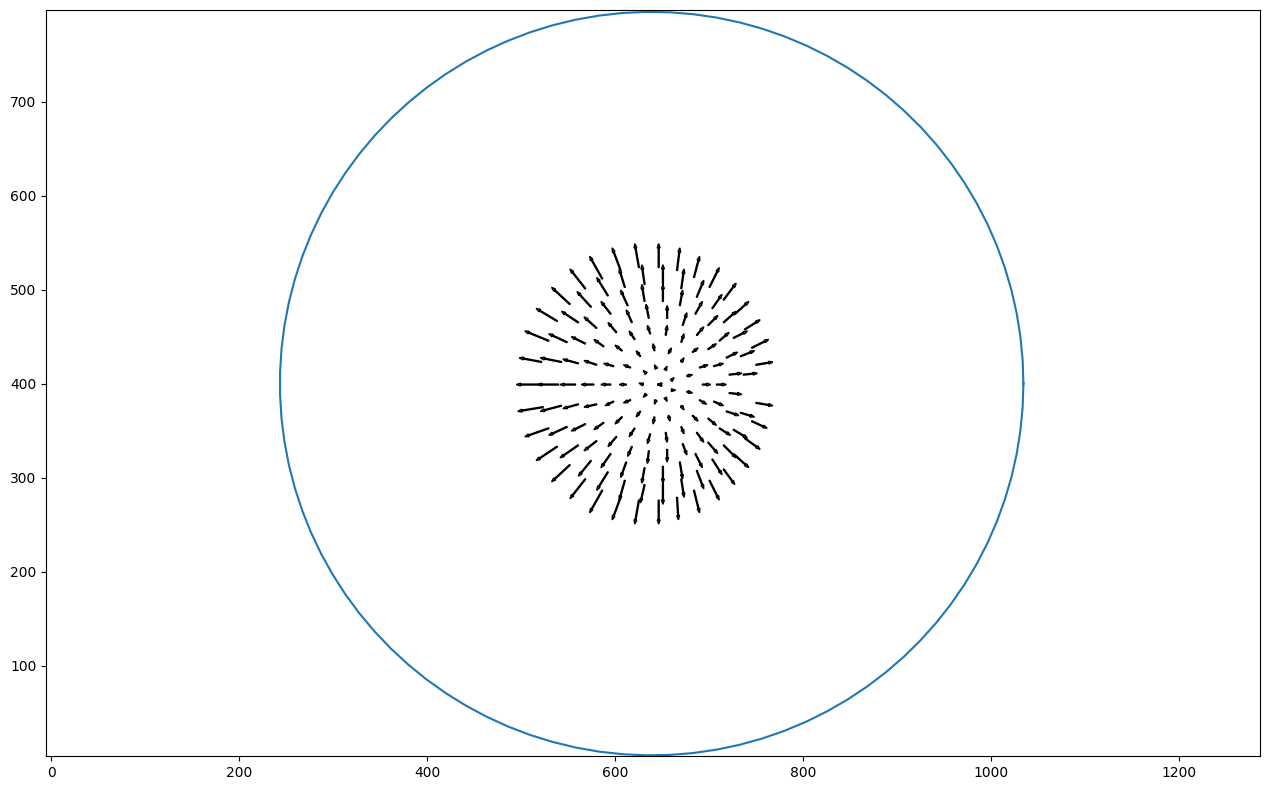

In [20]:
# Extract the point locations...
xp0 = []
yp0 = []
for loc in locations0:
    xp0.append(loc[0])
    yp0.append(loc[1])

xp1 = []
yp1 = []
for loc in locations1:
    xp1.append(loc[0])
    yp1.append(loc[1])

# Set up plot params
plt.figure(figsize=(12.8, 8))
plt.axis('equal')
plt.xlim((1, 1280))
plt.ylim((1, 800))
plt.tight_layout()

# Draw arrows between each corresponding pair of points
for i in range(len(xp0)):
    plt.arrow(xp0[i], yp0[i], xp1[i]-xp0[i], yp1[i]-yp0[i], width=1.0, length_includes_head=True)

# # Draw the points themselves
# plt.scatter(xp0, yp0, s=10.0, c='b')
# plt.scatter(xp1, yp1, s=10.0, c='r')

# Draw the bounding circle of the viewport for reference
an = np.linspace(0, 2.0 * np.pi, 100)
plt.plot(vp[0] + vp[2] * np.cos(an), vp[1] + vp[2] * np.sin(an))

In [21]:
# Compute distortion coefficients

xc = np.mean(xp0)
yc = np.mean(yp0)
# xc = 640
# yc = 400
print("Center of grid in image: ", xc, yc)

# mat = get_ideal_camera_matrix(100, 1280, 800)
# xf = mat[0,0] # x axis focal length
# yf = mat[1,1] # y axis focal length

# ignore focal length for now (it doesn't make a difference to the 
# actual calculations since everything gets scaled uniformly by it)
xf = 1
yf = 1

hl = len(locations1) # half length of A (half # of rows)
A = np.zeros((2*hl, 4))
i = 0 # index into row of A
for posn in locations1:
    x = posn[0]
    y = posn[1]
    # x = (posn[0] - xc) / xf
    # y = (posn[1] - yc) / yf
    # r2 = x*x + y*y
    # r1 = np.sqrt(r2)
    # r3 = r2 * r1
    # r4 = r2*r2
    
    # A[i,   0] = 1
    # A[i,   1] = r1
    # A[i,   0] = r2
    # A[i,   3] = r3
    # A[i,   1] = r4
    # A[i,   5] = (r2/x) + (2*x)
    # A[i,   6] = 2*y

    # A[i+1, 0] = 1
    # A[i+1, 1] = r1
    # A[i+1, 0] = r2
    # A[i+1, 3] = r3
    # A[i+1, 1] = r4
    # A[i+1, 5] = 2*x
    # A[i+1, 6] = (r2/y) + (2*y)

    A[i,   0] = 1
    A[i,   1] = x
    A[i,   2] = 0
    A[i,   3] = 0

    A[i+1, 0] = 0
    A[i+1, 1] = 0
    A[i+1, 2] = 1
    A[i+1, 3] = y

    i += 2

b = np.zeros((2*len(locations0), 1))
j = 0 # index into locations
for i in range(0, 2*len(locations0), 2):
    # b[i  ] = (locations0[j][0] / locations1[j][0]) - 1
    # b[i+1] = (locations0[j][1] / locations1[j][1]) - 1
    b[i  ] = locations0[j][0]
    b[i+1] = locations0[j][1]
    j += 1

# print(A)
# print(b)
# print()

# Using QR decomposition
Q, R = np.linalg.qr(A)
distortion_ceoffs = np.linalg.inv(R) @ Q.T @ b
print(distortion_ceoffs)
print()

# Using pseudo inverse
distortion_ceoffs_ = pseudo_inverse(A) @ b
print(distortion_ceoffs_)
print()

Center of grid in image:  642.03796 399.53165
[[105.88271255]
 [  0.83727478]
 [ 66.40293726]
 [  0.83389713]]

[[105.88271255]
 [  0.83727478]
 [ 66.40293726]
 [  0.83389713]]



0.08182148625101622


(508.850413225311, 761.4833136559375, 262.8482533347992, 536.6583755183932)

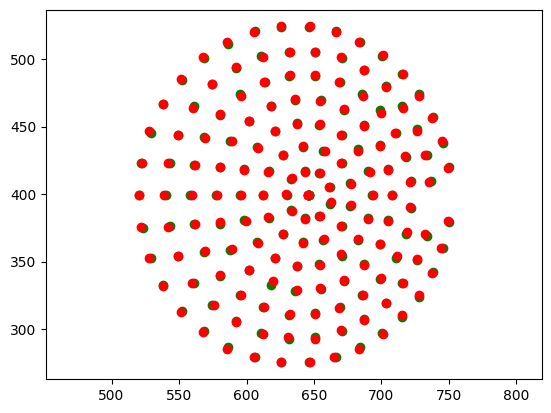

In [22]:
# Compute the re-projection error using the distortion coefficients

def apply_distortion(x:float, y:float, dist: np.ndarray) -> tuple[float, float]:
    # r2 = x*x + y*y
    # r1 = np.sqrt(r2)
    # r3 = r2*r1
    # r4 = r2*r2

    # x_ = x*(dist[0] + dist[1]*r1 + dist[2]*r2 + dist[3]*r3 + dist[4]*r4) + dist[5]*(r2 + 2*x*x) + dist[6]*2*x*y
    # y_ = y*(dist[0] + dist[1]*r1 + dist[2]*r2 + dist[3]*r3 + dist[4]*r4) + dist[5]*2*x*y + dist[6]*(r2 + 2*y*y)

    # x_ = x*(dist[0] + dist[1]*r2 + dist[2]*r4) + dist[3]*(r2 + 2*x*x) + dist[4]*2*x*y
    # y_ = y*(dist[0] + dist[1]*r2 + dist[2]*r4) + dist[3]*2*x*y + dist[4]*(r2 + 2*y*y)

    x_ = dist[0] + dist[1]*x
    y_ = dist[2] + dist[3]*y


    return x_, y_

projected = []
actual = []
for i in range(len(locations1)):
    # x = (locations1[i][0] - xc) / xf
    # y = (locations1[i][1] - yc) / yf
    x = locations1[i][0]
    y = locations1[i][1]
    x_, y_ = apply_distortion(x, y, distortion_ceoffs.flatten())
    projected.append([x_, y_])
    # projected.append([x, y])

    # ax = (locations0[i][0] - xc) / xf
    # ay = (locations0[i][1] - yc) / yf
    ax = locations0[i][0]
    ay = locations0[i][1]
    actual.append([ax, ay])

projected = np.array(projected)
actual = np.array(actual)
error = np.linalg.norm(projected - actual)/len(locations1)
print(error)

# Visualize the difference between the projected and actual points...
plt.scatter(actual[:,0], actual[:,1], c='g')
plt.scatter(projected[:,0], projected[:,1], c='r')
plt.axis('equal')